In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
%matplotlib inline
import os
import scipy.ndimage
import glob

In [2]:
def GetImg(img, window, cm, roi = None, roiSize = None, roiWindow = None, filename = None, dpi=200, color = 'w', 
           roiCircle = None):
    img = np.copy(img)
    ny = img.shape[0]
    nx = img.shape[1]

    
    if filename is not None:
        plt.ioff()
        fig = plt.figure(figsize=[nx / dpi, ny / dpi], frameon = (filename is None), dpi=dpi)
    else:
        fig = plt.figure(figsize=[nx / dpi, ny / dpi], dpi=dpi)
        
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # roi
    if roi is not None:
        if roiWindow is None: 
            roiWindow = window
        
        subImg = img[roi[0]:roi[2], roi[1]:roi[3]]
        subImg = scipy.ndimage.interpolation.zoom(subImg, 
                                                  (roiSize[0] / subImg.shape[0], roiSize[1] / subImg.shape[1]))
        subImg = (subImg - roiWindow[0]) / (roiWindow[1] - roiWindow[0])
    
    img = (img - window[0]) / (window[1] - window[0])
    
    if roi is not None:
        img[-subImg.shape[0]:, -subImg.shape[1]:] = subImg
    
    ax.imshow(img, cm, vmin = 0, vmax = 1)
    
    if roi is not None:
        dashLine = ax.plot([roi[1], roi[1], roi[3], roi[3], roi[1]], 
                           [roi[0], roi[2], roi[2], roi[0], roi[0]], 
                           color + '--', lineWidth = 1)
        dashLine[0].set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                      path_effects.Normal()])
        
        solidLine = ax.plot([nx - roiSize[0], nx - roiSize[0], nx-1, nx-1, nx - roiSize[0]], 
                            [ny - roiSize[1], ny - 1, ny - 1, ny - roiSize[1], ny - roiSize[1]], color+'-', lineWidth=1)
        solidLine[0].set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                       path_effects.Normal()])
    
    if roiCircle is not None:
        # x, y, r
        circle = plt.Circle(roiCircle[:2], roiCircle[2], color='yellow', linestyle='--', fill = False)
        ax.add_artist(circle)
    
    if filename is not None:
        plt.savefig(filename)
        plt.close()
        plt.ion()
    
#     return fig

In [3]:
def GetMask(roiCircle, img):
    mask= np.zeros_like(img)
    cx = roiCircle[1]
    cy = roiCircle[0]
    r = roiCircle[2]
    
    sx = int(cx - r - 1)
    ex = int(cx + r + 1)
    sy = int(cy - r - 1)
    ey = int(cy + r + 1)
    
    for x in range(sx, ex + 1):
        for y in range(sy, ey + 1):
            if (x - cx)**2 + (y - cy)**2 <= r**2:
                mask[x,y] = 1
    
    return mask
    

In [4]:
# iodine
imgDirs = {
    'Gaussian': '../../train/recon/gaussian_2d/1.25e-4/', 
    'TV': '../../train/recon/tv_2d/4e-5/', 
    'NLV': '../../train/recon/nlm_2d/5e-4_sigma_0.075/', 
    'CSC': '../../train/recon/csc_2d/0.02/', 
    'N2N(d)': '../../train/recon/n2n_denoising_2d/denoising/2/', 
    'N2N(no pre)': '../../train/recon/n2n_2d/encoder_decoder_all_no_init/7.5e-4/', 
    'N2N': '../../train/recon/n2n_2d/encoder_decoder_all/7.5e-4/', 
    'N2C': '../../train/recon/n2c_2d/encoder_decoder/final/'
}
ref = np.load('../../train/recon/data/sino/full_gaussian.npy')[:, 128:-128, 128:-128, 0].transpose((0, 2, 1)) / 0.019

In [5]:
outDirBase = '../../train/recon/eval/'

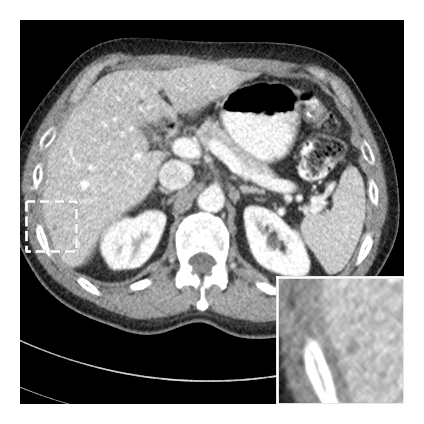

In [6]:
iSlice = 9
roix = 180
roiy = 5
roi = [roix, roiy, roix+50, roiy+50]
roiSize = [128, 128]
debug = True
if debug:
    GetImg(ref[iSlice, ...], [0.84, 1.24], 'gray', roi, roiSize)
else:
    outDir = os.path.join(outDirBase, str(iSlice))
    if not os.path.exists(outDir):
        os.makedirs(outDir)
    
    for name in imgDirs:
        img = np.load(os.path.join(imgDirs[name], str(iSlice), 'recon.npy'))
        if name == 'N2C':
            img = img[128:-128, 128:-128, 0].transpose()
        else:
            img = img[0,128:-128, 128:-128, 0].transpose()
        GetImg(img, [0.84, 1.24], 'gray', roi, roiSize, filename = os.path.join(outDir, name))
    
    GetImg(ref[iSlice, ...], [0.84, 1.24], 'gray', roi, roiSize, filename = os.path.join(outDir, 'ref'))

In [11]:
iSlice = 37
roix = 85
roiy = 185
roi = [roix, roiy, roix+30, roiy+30]
roiCircle = [75, 150, 25]
roiSize = [128, 128]
debug = False
if debug:
    GetImg(ref[iSlice, ...], [0.84, 1.24], 'gray', roi, roiSize, roiCircle = roiCircle)
    
    mask = GetMask(roiCircle, ref[iSlice, ...])
    std = np.std(ref[iSlice, ...].flatten()[np.where(mask.flatten())])
    print (std)
else:
    outDir = os.path.join(outDirBase, str(iSlice))
    if not os.path.exists(outDir):
        os.makedirs(outDir)
    
    for name in imgDirs:
        img = np.load(os.path.join(imgDirs[name], str(iSlice), 'recon.npy'))
        if name == 'N2C':
            img = img[128:-128, 128:-128, 0].transpose()
        else:
            img = img[0, 128:-128, 128:-128, 0].transpose()
        GetImg(img, [0.84, 1.24], 'gray', roi, roiSize, filename = os.path.join(outDir, name), roiCircle = roiCircle)
        
        mask = GetMask(roiCircle, img)
        std = np.std(img.flatten()[np.where(mask.flatten())])
        print (name, std)
        
    GetImg(ref[iSlice, ...], [0.84, 1.24], 'gray', roi, roiSize, filename = os.path.join(outDir, 'ref'), roiCircle = roiCircle)
    
    mask = GetMask(roiCircle, ref[iSlice, ...])
    std = np.std(ref[iSlice,...].flatten()[np.where(mask.flatten())])
    print ('ref', std)

Gaussian 0.03039175
TV 0.0055972
NLV 0.010901175
CSC 0.008379154
N2N(d) 0.017433183
N2N(no pre) 0.015116784
N2N 0.014141554
N2C 0.005610861
ref 0.015065653


In [4]:
# dose study
imgDirs = {
    'Gaussian': '../../train/recon/gaussian_fp/', 
#     'TV': '../../train/recon/tv_2d/4e-5/', 
    'NLV': '../../train/recon/nlm_fp/', 
#     'CSC': '../../train/recon/csc_2d/0.02/', 
#     'N2N(d)': '../../train/recon/n2n_denoising_2d/denoising/2/', 
#     'N2N(no pre)': '../../train/recon/n2n_2d/encoder_decoder_all_no_init/7.5e-4/', 
    'N2N': '../../train/recon/n2n_fp/encoder_decoder/', 
    'N2C': '../../train/recon/n2c_fp/encoder_decoder/'
}
ref = np.load('../../train/recon/data/fp/full_hann.npy')[:, 128:-128, 128:-128, 0].transpose((0, 2, 1)) / 0.019

In [5]:
params = {
    'Gaussian': ['1.25e-4', '1.25e-4', '1.25e-4', '1.25e-4', '1.25e-4'],
    'NLV': ['2.5e-4', '5e-4', '5e-4', '7.5e-4', '1e-3'],
    'N2N': ['7.5e-4', '1e-3', '1.25e-3', '1.25e-3', '1.25e-3'],
    'N2C': ['final'] * 5
}
doseLevel = [0.5, 0.333, 0.25, 0.166, 0.125]

In [6]:
outDirBase = '../../train/recon/eval/dose'

In [14]:
iSlice = 16
roix = 75
roiy = 160
# roi = [roix, roiy, roix+50, roiy+50]
roi = None
roiSize = [128, 128]
debug = True
if debug:
#     GetImg(ref[iSlice, ...], [0.84, 1.24], 'gray', roi, roiSize)
    GetImg(ref[iSlice, 64:224, 64:224], [0.84, 1.24], 'gray')
else:
    for name in imgDirs:
        for i, dose in enumerate(doseLevel):
            outDir = os.path.join(outDirBase, str(dose))
            if not os.path.exists(outDir):
                os.makedirs(outDir)
            
            filename = os.path.join(imgDirs[name], str(dose), params[name][i], str(iSlice), 'recon.npy')
            img = np.load(filename)

            if name == 'N2C':
                img = img[128:-128, 128:-128, 0].transpose()
            else:
                img = img[0, 128:-128, 128:-128, 0].transpose()
            
            img = img[64:224, 64:224]

            GetImg(img, [0.84, 1.24], 'gray', roi, roiSize, filename = os.path.join(outDir, name))

    GetImg(ref[iSlice, 64:224, 64:224], [0.84, 1.24], 'gray', roi, roiSize, filename = os.path.join(outDirBase, 'ref'))

In [18]:
# convergence study
imgDirs = {
    'N2N': '../../train/recon/n2n_2d/converge/alter_os/patch_img_pre_train/', 
    'N2N_no_os': '../../train/recon/n2n_2d/converge/alter_no_os/patch_img_pre_train/', 
}
ref = np.load('../../train/recon/data/sino/full_gaussian.npy')[:, 128:-128, 128:-128, 0].transpose((0, 2, 1)) / 0.019

In [19]:
outDirBase = '../../train/recon/eval/converge'

In [21]:
iSlice = 16
roix = 75
roiy = 160
# roi = [roix, roiy, roix+50, roiy+50]
roi = None
roiSize = [128, 128]
debug = False
if debug:
    GetImg(ref[iSlice, 64:224, 64:224], [0.84, 1.24], 'gray', roi, roiSize)
else:
    for name in imgDirs:
        outDir = os.path.join(outDirBase, str(iSlice))
        if not os.path.exists(outDir):
            os.makedirs(outDir)

        filenames = glob.glob(os.path.join(imgDirs[name], str(iSlice), 'recon_*.npy'))
        for filename in filenames:
            img = np.load(filename)[0, 128:-128, 128:-128, 0].transpose()
            img = img[64:224, 64:224]
            
            GetImg(img, [0.84, 1.24], 'gray', roi, roiSize, 
                   filename = os.path.join(outDir, name + '_' + os.path.basename(filename).strip('.npy').split('_')[1]))